In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cross sell prediction/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cross sell prediction/test.csv')

In [76]:
df = pd.merge(train,test,on=[x for x in train.columns if x not in ['Response']],how='outer')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1.0
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0.0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1.0
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0.0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0.0


In [77]:
#Check the data distribution in the dataframe
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,381109.000000
mean,254073.500000,38.808413,0.997936,26.406572,0.458667,30554.453041,111.975838,154.340123,0.122563
std,146689.259281,15.500179,0.045388,13.224921,0.498289,17146.574625,54.246027,83.668793,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,127037.250000,25.000000,1.000000,15.000000,0.000000,24381.000000,26.000000,82.000000,0.000000
50%,254073.500000,36.000000,1.000000,28.000000,0.000000,31661.000000,133.000000,154.000000,0.000000
75%,381109.750000,49.000000,1.000000,35.000000,1.000000,39403.750000,152.000000,227.000000,0.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


Here the Annual Premium column seems to contain some outliers as the maximum value is way too high than the mean of the data.<br>So visualising the column values by boxplot.

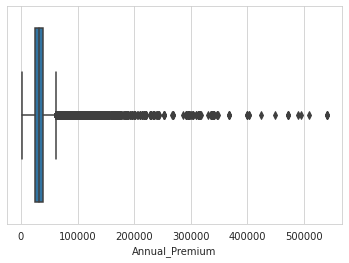

In [78]:
sns.set_style('whitegrid')
sns.boxplot(x=df['Annual_Premium'])

In [79]:
#Set an upper limit of 1,50,000 to the premium paid by the customer
df.loc[df['Annual_Premium']>150000,'Annual_Premium'] = 150000

## Feature Engineering

In [80]:
#Normalising the data of Age, Annual Premium and Vintage columns 
df['log_age'] = np.log(df['Age'])
df['sqrt_premium'] = np.sqrt(df['Annual_Premium'])
df['log_vintage'] = np.log(df['Vintage'])

In [81]:
#Calculating mean and std of premium paid and vintage on Previously Insured per Sales Channel used
group = df.groupby(['Policy_Sales_Channel','Previously_Insured'])['Annual_Premium'].agg(['mean','std'])
group.columns = [x + '_channel_insured_premium' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Policy_Sales_Channel','Previously_Insured'],how='left')

group = df.groupby(['Policy_Sales_Channel','Previously_Insured'])['Vintage'].agg(['mean','std'])
group.columns = [x + '_channel_insured_vintage' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Policy_Sales_Channel','Previously_Insured'],how='left')

In [82]:
#Calculating mean and std of premium paid and vintage on Previously Insured per Region
group = df.groupby(['Region_Code','Previously_Insured'])['Annual_Premium'].agg(['mean','std'])
group.columns = [x +'_region_insured_premium' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Region_Code','Previously_Insured'],how='left')

group = df.groupby(['Region_Code','Previously_Insured'])['Vintage'].agg(['mean','std'])
group.columns = [x +'_region_insured_vintage' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Region_Code','Previously_Insured'],how='left')

In [83]:
#Calculating mean and std of premium paid and vintage on Vehicle Damage per Region
group = df.groupby(['Region_Code','Vehicle_Damage'])['Annual_Premium'].agg(['mean','std'])
group.columns = [x +'_region_damage_premium' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Region_Code','Vehicle_Damage'],how='left')

group = df.groupby(['Region_Code','Vehicle_Damage'])['Vintage'].agg(['mean','std'])
group.columns = [x +'_region_damage_vintage' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Region_Code','Vehicle_Damage'],how='left')

In [84]:
#Calculating mean and std of premium paid and vintage on the basis of Vehicle Damage
group = df.groupby(['Vehicle_Damage'])['Annual_Premium'].agg(['mean','std'])
group.columns = [x + '_damage_premium' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Vehicle_Damage'],how='left')

group = df.groupby(['Vehicle_Damage'])['Vintage'].agg(['mean','std'])
group.columns = [x + '_damage_vintage' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Vehicle_Damage'],how='left')

In [85]:
#Calculating mean and std of premium paid and vintage on Vehicle Damage per customer Age
group = df.groupby(['Age','Vehicle_Damage'])['Vintage'].agg(['mean','std'])
group.columns = [x +'_age_damage_vintage' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Age','Vehicle_Damage'],how='left')

group = df.groupby(['Age','Vehicle_Damage'])['Annual_Premium'].agg(['mean','std'])
group.columns = [x +'_age_damage_premium' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Age','Vehicle_Damage'],how='left')

In [86]:
#Counting the number of customers for Previously Insured column agewise
group = df.groupby(['Age']).agg(cnt_age_insured = ('Previously_Insured','count'))
df = pd.merge(df,group,on=['Age'],how='left')

group = df.groupby(['Region_Code']).agg(cnt_region_insured = ('Previously_Insured','count'))
df = pd.merge(df,group,on=['Region_Code'],how='left')

In [87]:
le = LabelEncoder()
for i in ['Gender','Vehicle_Age','Vehicle_Damage']:
  df[i] = le.fit_transform(df[i])

In [88]:
#Converting float dtypes column to int for the catboost model to accept it
df['Region_Code'] = df['Region_Code'].astype(int)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)

In [89]:
X = df[df['Response'].notnull()]
X_valid = df[df['Response'].isnull()]

## Model Testing and Fitting

Out of the different models fitted, the CatBoost model gave the best auc score for the given dataset.

In [90]:
cat_col = ['Gender','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel']

#cv_data = cb.Pool(X.drop(columns=['id','Response']),label=X['Response'],cat_features=cat_col)

params = {'iterations':2000,
         'learning_rate':0.05,
         'thread_count':4,
         'eval_metric':'AUC',
          'loss_function':'Logloss'}

#cv_res = cb.cv(dtrain=cv_data,early_stopping_rounds=100,nfold=5,params=params,plot=True)

In [91]:
#The cross validation gave an AUC score of 0.8589179 for the model of 384 trees with a learning rate of 0.05 as the best one
cat_col = ['Gender','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel']

cbc_new = cb.CatBoostClassifier(iterations=384,learning_rate=0.05,thread_count=4,cat_features=cat_col,eval_metric='AUC')
cbc_new.fit(X.drop(columns=['id','Response']),X['Response'])

y_pred_cbc_new = cbc_new.predict_proba(X_valid.drop(columns=['id','Response']))[:,1]
test_res = test['id']
test_res = pd.concat([test_res,pd.DataFrame(y_pred_cbc_new,columns=['Response'])],axis=1)
test_res.set_index('id',inplace=True)
test_res.to_csv('/content/drive/My Drive/Colab Notebooks/cross sell prediction/sub_cbc_final.csv')

0:	total: 471ms	remaining: 3m
1:	total: 982ms	remaining: 3m 7s
2:	total: 1.46s	remaining: 3m 5s
3:	total: 1.92s	remaining: 3m 2s
4:	total: 2.44s	remaining: 3m 4s
5:	total: 2.93s	remaining: 3m 4s
6:	total: 3.41s	remaining: 3m 3s
7:	total: 3.87s	remaining: 3m 2s
8:	total: 4.36s	remaining: 3m 1s
9:	total: 4.82s	remaining: 3m
10:	total: 5.3s	remaining: 2m 59s
11:	total: 5.74s	remaining: 2m 57s
12:	total: 6.22s	remaining: 2m 57s
13:	total: 6.69s	remaining: 2m 56s
14:	total: 7.16s	remaining: 2m 56s
15:	total: 7.61s	remaining: 2m 55s
16:	total: 8.05s	remaining: 2m 53s
17:	total: 8.52s	remaining: 2m 53s
18:	total: 8.9s	remaining: 2m 51s
19:	total: 9.38s	remaining: 2m 50s
20:	total: 9.87s	remaining: 2m 50s
21:	total: 10.4s	remaining: 2m 50s
22:	total: 10.8s	remaining: 2m 49s
23:	total: 11.2s	remaining: 2m 48s
24:	total: 11.7s	remaining: 2m 48s
25:	total: 12.1s	remaining: 2m 47s
26:	total: 12.6s	remaining: 2m 46s
27:	total: 13s	remaining: 2m 45s
28:	total: 13.5s	remaining: 2m 45s
29:	total: 14s	

Text(0, 0.5, 'Features')

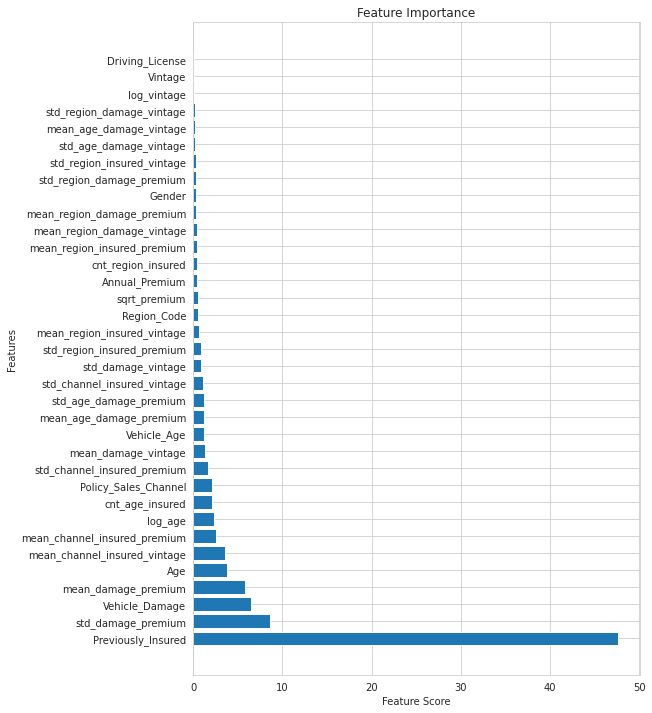

In [92]:
#Plotting Feature Importance
score_dict = {}
feature_importances = cbc_new.get_feature_importance()
feature_names = X.drop(columns=['id','Response']).columns

for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
  score_dict.update({name:score})

score_list = score_dict.items()
x,y = zip(*score_list)

plt.figure(figsize=(8,12))
plt.title('Feature Importance')
plt.barh(x,y)
plt.xlabel('Feature Score')
plt.ylabel('Features')